# Kaggler: SenNet + HOA - Hacking the Human Vasculature in 3D

<hr>
<b>Team:</b> Kaggler <br>
<b>Team Members:</b> Hyunji Cha, Minjae Jeong, Min Joh, Jin You <br><br>

> <b>Competition Information:</b><br>
Title: SenNet + HOA - Hacking the Human Vasculature in 3D <br>
Host: SenNet + HOA <br>
Platform: Kaggle <br>
Final Submission Deadline: February 6, 2024 <br>
Link: https://www.kaggle.com/competitions/blood-vessel-segmentation <br>

<hr>

## 0. Setups

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install torchinfo

In [ ]:
import os
import time
import sys

import numpy as np
import pandas as pd
from skimage import io, transform, exposure
from tqdm import tqdm
import albumentations as Alb

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchinfo import summary

## 1. Configuration

In [ ]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """
    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = '/content/drive/MyDrive/blood-vessel-segmentation'
    # DATASET_DIRECTORY = os.path.abspath(os.path.join("..", "blood-vessel-segmentation"))
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

    # ============== Model Configuration =============
    MODEL_NAME = 'Attention UNet'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Model Paths =============
    # List of paths to trained model weights
    #CHECKPOINT_PATH = os.path.abspath("checkpoints")
    CHECKPOINT_PATH = os.path.abspath('/content/drive/MyDrive/checkpoints')
    TRAINED_MODEL = f"{MODEL_NAME}_{DATASET_NAME}_checkpoint.pth"

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (512, 512)  # Size of the input images (height x width)
    GAMMA = 1
    NUM_IMAGES = None # 'None' for all images

    # ============== Training and Validation Parameters =============
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 1  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 100
    NUM_WORKERS = 0 # Number of processes
    TRAIN_TEST_SPLIT_RATIO = 0.2 # for test subset

NameError: name 'os' is not defined

In [ ]:
print(CFG.DEVICE)

NameError: name 'CFG' is not defined

## 2. Load Dataset

### 2,1 Custom Dataset Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path=None, target_image_size=(512, 512), convert_size=True, gamma=1, image_format=".tif"):
        # File IO
        self.image_path = image_path
        self.image_format = image_format
        self.image_filenames = sorted([os.path.join(self.image_path, filename) for filename in os.listdir(self.image_path) if filename.endswith(self.image_format)])
        print(f"{len(self.image_filenames)} images are loaded.")

        # If masks (labels) are given
        self.mask_path = mask_path
        if self.mask_path:
            self.mask_filenames = sorted([os.path.join(self.mask_path, filename) for filename in os.listdir(self.mask_path) if filename.endswith(self.image_format)])
            if not len(self.mask_filenames) == len(self.image_filenames):
                raise(f"Number of images and labels are not matched: {len(self.image_filenames)} images and {len(self.mask_filenames)} labels.")
            print(f"{len(self.mask_filenames)} labels are loaded.")

        # Image processing
        self.target_image_size = target_image_size
        self.convert_size = convert_size
        self.gamma = gamma

        # Process and print the size of the first image if convert_size is True
        if self.convert_size and len(self.image_filenames) > 0:
            first_image = io.imread(self.image_filenames[0])
            resized_image = self.resize_and_pad(first_image, self.target_image_size)
            print(f"Original size: {first_image.shape}, Converted size: {resized_image.shape}")

    def __getitem__(self, index):
        # Load image and convert to float32
        image = io.imread(self.image_filenames[index]).astype(np.float32)

        # Resize and pad the image if convert_size is True
        if self.convert_size:
            image = self.resize_and_pad(image, self.target_image_size, self.gamma)

        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])

        # If masks (labels) are given
        if self.mask_path:
            mask = io.imread(self.mask_filenames[index]).astype(np.uint8)
            mask = self.resize_and_pad(mask, self.target_image_size, is_mask=True)

            # Convert mask from [0, 255] to [0, 1]
            mask = (mask > 0).astype(np.uint8)  # This converts all non-zero values to 1

            return image, mask, image_filename

        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size, is_mask=False, gamma=1):
        """Resize an image or mask and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Set parameters for resizing based on whether it's an image or a mask
        if is_mask:
            # Use nearest-neighbor interpolation for masks
            order = 0
            anti_aliasing = False
        else:
            # Use bilinear interpolation (order=1) for images
            order = 1
            anti_aliasing = True

        # Resize image with preserve_range set to True
        image_resized = transform.resize(
            image,
            (new_h, new_w),
            anti_aliasing=anti_aliasing,
            mode='constant',
            preserve_range=True,  # Preserve the original image's intensity range
            order=order
        )

        # Apply gamma correction to images only
        if not is_mask and gamma != 1:
            image_resized = exposure.adjust_gamma(image_resized, gamma)

        # Add a channel dimension to grayscale images if necessary
        if len(image.shape) == 2:  # Grayscale image
            image_resized = image_resized[..., np.newaxis]

        # Initialize padded image
        padded_image = np.zeros((target_image_size[0], target_image_size[1], image_resized.shape[2]), dtype=image_resized.dtype)

        # Insert the resized image into the padded image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = image_resized

        return padded_image

### 2.2 Display Function

In [ ]:
def display_image(images, titles=None, max_cols=4):
    # Wrap single image in a list
    if not isinstance(images, list):
        images = [images]
        titles = [titles] if titles is not None else titles

    if titles is not None and not isinstance(titles, list):
        raise TypeError("Titles should be provided as a list or a single title for a single image.")

    if titles and len(images) != len(titles):
        raise ValueError("Every image should have a corresponding title.")

    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = num_images // cols + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 or cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()[:num_images]  # Limit to the number of images to avoid blank subplots

    for ax, img, title in zip(axes, images, titles or [None]*num_images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = img.transpose(1, 2, 0)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(2)

        ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 2.3 Load Dataset and Display Sample Image

In [ ]:
# Get dataset paths
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")

# Print current working directory and full paths for debugging
print("Current working directory:", os.getcwd())
print("Full image path:", os.path.abspath(image_path))
print("Full mask path:", os.path.abspath(mask_path))

# Initialize dataset
dataset = CustomDataset(image_path, mask_path, target_image_size=CFG.INPUT_IMAGE_SIZE, gamma=CFG.GAMMA)

Current working directory: /content
Full image path: /content/drive/MyDrive/blood-vessel-segmentation/train/kidney_1_dense/images
Full mask path: /content/drive/MyDrive/blood-vessel-segmentation/train/kidney_1_dense/labels
2279 images are loaded.
2279 labels are loaded.
Original size: (1303, 912), Converted size: (512, 512, 1)


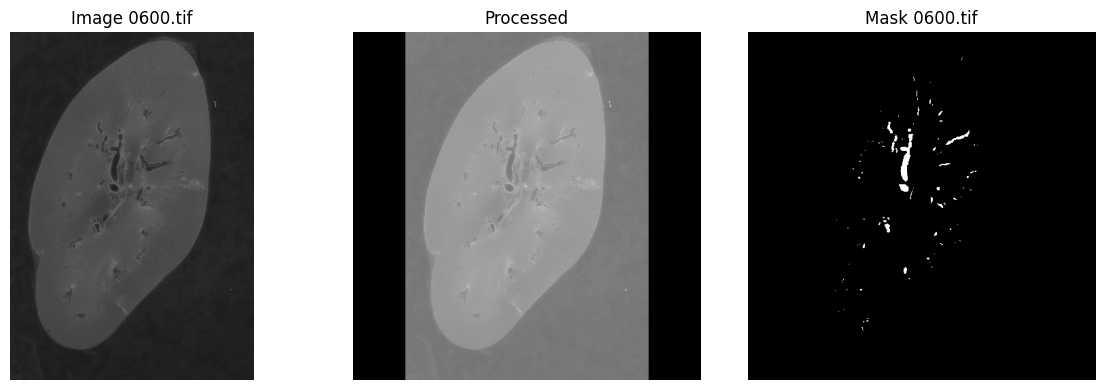

In [ ]:
index = 600
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", dataset[index][2]))
display_image([original_image, dataset[index][0], dataset[index][1]], [f"Image {dataset[index][2]}", "Processed", f"Mask {dataset[index][2]}"])

### 2.4 Train-Test-Split and DataLoader

In [ ]:
# Slice dataset
if not CFG.NUM_IMAGES:
    pass
elif CFG.NUM_IMAGES < 6:
    raise("Number of samples is not sufficient. Raise number over 6.")
else:
    # Create a subset of the dataset
    indices = torch.randperm(len(dataset)).tolist()
    subset_indices = indices[:CFG.NUM_IMAGES]
    subset_dataset = Subset(dataset, subset_indices)
    dataset = subset_dataset

# Calculate the sizes of train and test sets
total_size = len(dataset)
test_size = int(total_size * CFG.TRAIN_TEST_SPLIT_RATIO)
train_size = total_size - test_size

# Split the dataset into train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split the train dataset into train and validation datasets
val_size = int(train_size * CFG.TRAIN_TEST_SPLIT_RATIO)
new_train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [new_train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=CFG.NUM_WORKERS)

print("Numbers of batches in train, valid, test data loader are:")
print(f"Train: {len(train_loader)}, Validation: {len(val_loader)}, Test: {len(test_loader)}")

Numbers of batches in train, valid, test data loader are:
Train: 1460, Validation: 364, Test: 455


In [ ]:
data, target, filename = next(iter(train_loader))
print("Shape of the data: ", data.shape)  # Expected: [batch_size, 1, height, width]

Shape of the data:  torch.Size([1, 512, 512, 1])


In [ ]:
def check_target_masks(data_loader):
    for batch_index, (data, target, filename) in enumerate(tqdm(data_loader)):
        target_np = target.cpu().numpy()

        if not np.all(np.isin(target_np, [0, 1])):
            unique_values = np.unique(target_np)
            return False, f"Non-binary values found in batch {batch_index}. Unique values: {unique_values}"

    return True, "All target masks are binary (contain only 0s and 1s)"

is_binary, message = check_target_masks(train_loader)
print(message)
is_binary, message = check_target_masks(val_loader)
print(message)
is_binary, message = check_target_masks(test_loader)
print(message)

100%|██████████| 1460/1460 [19:39<00:00,  1.24it/s]


All target masks are binary (contain only 0s and 1s)


100%|██████████| 364/364 [05:06<00:00,  1.19it/s]


All target masks are binary (contain only 0s and 1s)


100%|██████████| 455/455 [06:12<00:00,  1.22it/s]

All target masks are binary (contain only 0s and 1s)


## 3. Image Augmentation

In [ ]:
def augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]

    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

## 4. Model

In [ ]:
# SSL certificate expired for se_resnext50_32x4d encoder
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 4.1 Attention U-Net ResNext50 32x4d

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * s

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c, out_c)
        self.c1 = conv_block(in_c[0]+out_c, out_c)

    def forward(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.c1(x)
        return x

class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(1, 64)  # Adjusted for 1 input channel
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        # Add more encoder blocks if needed to accommodate the larger input size

        self.b1 = conv_block(256, 512)

        self.d1 = decoder_block([512, 256], 256)
        self.d2 = decoder_block([256, 128], 128)
        self.d3 = decoder_block([128, 64], 64)
        # Add more decoder blocks symmetrically if more encoder blocks are added

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)  # Output for 1 channel

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)

        b1 = self.b1(p3)

        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output(d3)
        return output

NameError: name 'nn' is not defined

### 4.2 Model Summary

In [ ]:
model = attention_unet()
# summary(model, input_size = (CFG.BATCH_SIZE, 1, CFG.INPUT_IMAGE_SIZE[0], CFG.INPUT_IMAGE_SIZE[1]))
summary(model, input_size = (1, 1, CFG.INPUT_IMAGE_SIZE[0], CFG.INPUT_IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
attention_unet                           [1, 1, 512, 512]          --
├─encoder_block: 1-1                     [1, 64, 512, 512]         --
│    └─conv_block: 2-1                   [1, 64, 512, 512]         --
│    │    └─Sequential: 3-1              [1, 64, 512, 512]         37,824
│    └─MaxPool2d: 2-2                    [1, 64, 256, 256]         --
├─encoder_block: 1-2                     [1, 128, 256, 256]        --
│    └─conv_block: 2-3                   [1, 128, 256, 256]        --
│    │    └─Sequential: 3-2              [1, 128, 256, 256]        221,952
│    └─MaxPool2d: 2-4                    [1, 128, 128, 128]        --
├─encoder_block: 1-3                     [1, 256, 128, 128]        --
│    └─conv_block: 2-5                   [1, 256, 128, 128]        --
│    │    └─Sequential: 3-3              [1, 256, 128, 128]        886,272
│    └─MaxPool2d: 2-6                    [1, 256, 64, 64]          --
├

## 5. Evaluation

In [ ]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

### 5.1 Run-Length Encode and Decode

Run-Length Encoding (RLE) is a simple form of data compression where runs of data (i.e., sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count. It is particularly effective for data with many such runs, as it can significantly reduce the size of the data.

In the context of image segmentation, such as in a Kaggle competition for blood vessel segmentation from CT images, RLE is often used to encode binary masks. In a binary mask, each pixel is either part of the object of interest (e.g., a blood vessel) or the background. RLE can efficiently represent these masks, especially when large regions of pixels are the same (all vessel or all background).

The encoding typically works as follows:

1. The binary mask is flattened into a one-dimensional array (e.g., by taking each row of pixels in turn).
2. The algorithm goes through this array and counts the number of consecutive pixels with the same value.
3. Each run of pixels is then represented by two numbers: the start position in the flattened array and the length of the run.

For example, the array <code>[0, 0, 1, 1, 1, 0, 0]</code> would be encoded as <code>[2, 3]</code> in RLE, meaning that starting from the third element, there are three consecutive 1s.

### 5.2 Loss Functions

#### 5.2.1. DICE Loss
Dice loss is particularly useful for data with imbalanced classes. It measures the overlap between the predicted segmentation and the ground truth.

In [ ]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

#### 5.2.2. Jaccard/Intersection over Union (IoU) Loss
Similar to Dice loss, IoU is another common metric for the evaluation of object detection algorithms, such as image segmentation.

In [ ]:
class IoULoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU

#### 5.2.3 Focal Loss
This loss function is designed to address class imbalance by down-weighting well-classified examples.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### 5.4 Metrics

In [ ]:
def calculate_metrics(y_pred, y_true):
    """
    Calculates IOU, F1 score, precision, recall, and accuracy for U-Net predictions using NumPy.

    Arguments:
    y_true -- the ground truth labels (a binary array of 0s and 1s)
    y_pred -- the predicted labels (a binary array of 0s and 1s)

    Returns:
    A dictionary containing the IOU, F1 score, precision, recall, and accuracy.
    """
    with torch.no_grad():
        # Convert probability output to binary predictions
        y_pred = (y_pred > 0.5).float()

        # Flatten the arrays
        y_true = y_true.detach().cpu().numpy().flatten()
        y_pred = y_pred.detach().cpu().numpy().flatten()

        # Calculate true positives, false positives, and false negatives
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        # Very small number to prevent infinity when dividing zero
        eps = 1e-8

        # Calculate IOU
        iou = tp / (tp + fp + fn + eps)

        # Calculate precision
        precision = tp / (tp + fp + eps)

        # Calculate recall
        recall = tp / (tp + fn + eps)

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall + eps)

        # Calculate accuracy
        accuracy = np.sum(y_true == y_pred) / len(y_true)

    # Return a dictionary containing the metrics
    metrics = {"IoU_Score": iou, "F1_Score": f1_score, "Precision": precision, "Recall": recall, "Accuracy": accuracy}
    return metrics

## 6. Train

### 6.1 Trainer Class

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, checkpoint_path, model_name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.checkpoint_path = checkpoint_path
        self.model_name = model_name
        self.best_valid_loss = float('inf')

    def train_epoch(self):
        self.model.train()
        total_train_loss = 0  # Initialize cumulative loss to zero

        for batch_index, batch in enumerate(tqdm(self.train_loader)):
            self.optimizer.zero_grad()
            data, target, filename = batch

            data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
            target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

            # Convert data and target to float
            data = data.float()
            target = target.float()

            output = self.model(data)
            train_loss = self.criterion(output, target)
            train_loss.backward()
            self.optimizer.step()

            total_train_loss += train_loss.item()

        average_train_loss = total_train_loss/len(self.train_loader)
        return average_train_loss

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_index, batch in enumerate(tqdm(self.val_loader)):
                data, target, filename = batch
                data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
                target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

                # Convert data and target to float
                data = data.float()
                target = target.float()

                output = self.model(data)
                val_loss += self.criterion(output, target).item()
        return val_loss / len(self.val_loader.dataset)

    def train(self, epochs):
        # Initialize training dataframe
        train_df = pd.DataFrame(columns=[
            "Epoch",
            "Train_Loss",
            "Valid_Loss",
            "Time_Per_Iteration"
        ])

        for epoch in range(epochs):
            print(f"\nEpoch # {epoch+1}")
            start_time = time.time()
            train_loss = self.train_epoch()
            val_loss = self.validate()
            iteration_time = (time.time() - start_time) / len(self.train_loader)

            # Convert train_loss and val_loss to Python scalars
            train_loss_scalar = train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss
            val_loss_scalar = val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss

            # Create a new DataFrame for the current epoch's results
            result_df = pd.DataFrame({
                "Epoch": [epoch + 1],
                "Train_Loss": [train_loss_scalar],
                "Valid_Loss": [val_loss_scalar],
                "Time_Per_Iteration": [iteration_time]
            })

            # Append the new DataFrame to train_df
            train_df = pd.concat([train_df, result_df], ignore_index=True)

            # Check and create 'checkpoints' directory if it doesn't exist
            if not os.path.exists(self.checkpoint_path):
                os.makedirs(os.path.dirname(self.checkpoint_path), exist_ok=True)

            # Save the DataFrame to a CSV file
            train_df.to_csv(os.path.join(self.checkpoint_path, f"{self.model_name}.csv"))

            # Save model if the valid loss is lower than the previous ones
            if val_loss < self.best_valid_loss:
                print(f"Train Loss: {train_loss:2.6f}, Validation Loss: {self.best_valid_loss:2.6f} -> {val_loss: 2.6f}")
                self.best_valid_loss = val_loss
                self.save_model(self.model, self.checkpoint_path, self.model_name)
                print(f"Saved model at: {os.path.abspath(self.model_name)}")
            else:
                print(f"Train Loss: {train_loss:2.6f}, Validation Loss: {val_loss:2.6f}")

        return self.model, train_df

    def save_model(self, model, path, filename):
        # make directory if there is not
        if not os.path.exists(path):
            os.makedirs(path)

        # save weight values in .pth file
        torch.save(model.state_dict(), os.path.join(path, filename))

### 6.2 Train Model

In [ ]:
# Initialize trainer class
trainer = Trainer(model,
                train_loader,
                val_loader,
                optimizer=optim.Adam(model.parameters(),lr=CFG.LEARNING_RATE),
                criterion=DiceLoss(),
                device=CFG.DEVICE,
                checkpoint_path=CFG.CHECKPOINT_PATH,
                model_name=CFG.TRAINED_MODEL
)

# Train the model
model, train_df = trainer.train(epochs=CFG.NUM_EPOCHS)


Epoch # 1


100%|██████████| 364/364 [00:11<00:00, 31.29it/s]


Train Loss: 0.804381, Validation Loss: inf ->  0.387028
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 2


100%|██████████| 364/364 [00:11<00:00, 31.48it/s]


Train Loss: 0.239740, Validation Loss: 0.387028 ->  0.160971
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 3


100%|██████████| 364/364 [00:11<00:00, 31.74it/s]


Train Loss: 0.161989, Validation Loss: 0.407241

Epoch # 4


100%|██████████| 364/364 [00:11<00:00, 32.05it/s]


Train Loss: 0.140258, Validation Loss: 0.160971 ->  0.126282
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 5


100%|██████████| 364/364 [00:11<00:00, 31.55it/s]


Train Loss: 0.140887, Validation Loss: 0.126282 ->  0.121123
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 6


100%|██████████| 364/364 [00:11<00:00, 31.36it/s]


Train Loss: 0.124505, Validation Loss: 0.121123 ->  0.111104
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 7


100%|██████████| 364/364 [00:11<00:00, 31.90it/s]


Train Loss: 0.109697, Validation Loss: 0.111104 ->  0.107728
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 8


100%|██████████| 364/364 [00:11<00:00, 31.60it/s]


Train Loss: 0.124677, Validation Loss: 0.116348

Epoch # 9


100%|██████████| 364/364 [00:11<00:00, 31.57it/s]


Train Loss: 0.136816, Validation Loss: 0.231760

Epoch # 10


100%|██████████| 364/364 [00:11<00:00, 31.85it/s]


Train Loss: 0.119809, Validation Loss: 0.107728 ->  0.103549
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 11


100%|██████████| 364/364 [00:11<00:00, 31.72it/s]


Train Loss: 0.115754, Validation Loss: 0.148970

Epoch # 12


100%|██████████| 364/364 [00:11<00:00, 31.66it/s]


Train Loss: 0.118857, Validation Loss: 0.353019

Epoch # 13


100%|██████████| 364/364 [00:11<00:00, 31.61it/s]


Train Loss: 0.131011, Validation Loss: 0.115208

Epoch # 14


100%|██████████| 364/364 [00:11<00:00, 31.58it/s]


Train Loss: 0.119649, Validation Loss: 0.105339

Epoch # 15


100%|██████████| 364/364 [00:11<00:00, 31.57it/s]


Train Loss: 0.110486, Validation Loss: 0.103549 ->  0.102806
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 16


100%|██████████| 364/364 [00:11<00:00, 31.83it/s]


Train Loss: 0.124799, Validation Loss: 0.102806 ->  0.101927
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 17


100%|██████████| 364/364 [00:11<00:00, 31.76it/s]


Train Loss: 0.105554, Validation Loss: 0.106645

Epoch # 18


100%|██████████| 364/364 [00:11<00:00, 31.43it/s]


Train Loss: 0.106990, Validation Loss: 0.112838

Epoch # 19


100%|██████████| 364/364 [00:11<00:00, 31.79it/s]


Train Loss: 0.102451, Validation Loss: 0.109379

Epoch # 20


100%|██████████| 364/364 [00:11<00:00, 31.50it/s]


Train Loss: 0.102950, Validation Loss: 0.101927 ->  0.099511
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 21


100%|██████████| 364/364 [00:11<00:00, 31.54it/s]


Train Loss: 0.100071, Validation Loss: 0.114479

Epoch # 22


100%|██████████| 364/364 [00:11<00:00, 31.61it/s]


Train Loss: 0.110767, Validation Loss: 0.130779

Epoch # 23


100%|██████████| 364/364 [00:11<00:00, 31.54it/s]


Train Loss: 0.099574, Validation Loss: 0.099511 ->  0.096067
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 24


100%|██████████| 364/364 [00:11<00:00, 31.41it/s]


Train Loss: 0.097800, Validation Loss: 0.116034

Epoch # 25


100%|██████████| 364/364 [00:11<00:00, 31.33it/s]


Train Loss: 0.098616, Validation Loss: 0.102192

Epoch # 26


100%|██████████| 364/364 [00:11<00:00, 31.79it/s]


Train Loss: 0.095215, Validation Loss: 0.096067 ->  0.095660
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 27


100%|██████████| 364/364 [00:11<00:00, 31.76it/s]


Train Loss: 0.094762, Validation Loss: 0.095660 ->  0.092600
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 28


100%|██████████| 364/364 [00:11<00:00, 31.52it/s]


Train Loss: 0.095665, Validation Loss: 0.093698

Epoch # 29


100%|██████████| 364/364 [00:11<00:00, 31.80it/s]


Train Loss: 0.107922, Validation Loss: 0.094374

Epoch # 30


100%|██████████| 364/364 [00:11<00:00, 31.47it/s]


Train Loss: 0.096646, Validation Loss: 0.093950

Epoch # 31


100%|██████████| 364/364 [00:11<00:00, 31.65it/s]


Train Loss: 0.091241, Validation Loss: 0.092600 ->  0.090528
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 32


100%|██████████| 364/364 [00:11<00:00, 31.68it/s]


Train Loss: 0.093093, Validation Loss: 0.094296

Epoch # 33


100%|██████████| 364/364 [00:11<00:00, 31.59it/s]


Train Loss: 0.092262, Validation Loss: 0.090829

Epoch # 34


100%|██████████| 364/364 [00:11<00:00, 31.41it/s]


Train Loss: 0.088047, Validation Loss: 0.090528 ->  0.089454
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 35


100%|██████████| 364/364 [00:11<00:00, 31.76it/s]


Train Loss: 0.091818, Validation Loss: 0.101295

Epoch # 36


100%|██████████| 364/364 [00:11<00:00, 31.80it/s]


Train Loss: 0.091755, Validation Loss: 0.107413

Epoch # 37


100%|██████████| 364/364 [00:11<00:00, 31.63it/s]


Train Loss: 0.088375, Validation Loss: 0.090180

Epoch # 38


100%|██████████| 364/364 [00:11<00:00, 31.69it/s]


Train Loss: 0.085493, Validation Loss: 0.091999

Epoch # 39


100%|██████████| 364/364 [00:11<00:00, 31.79it/s]


Train Loss: 0.094420, Validation Loss: 0.090452

Epoch # 40


100%|██████████| 364/364 [00:11<00:00, 31.70it/s]


Train Loss: 0.087838, Validation Loss: 0.089683

Epoch # 41


100%|██████████| 364/364 [00:11<00:00, 31.99it/s]


Train Loss: 0.083928, Validation Loss: 0.101806

Epoch # 42


100%|██████████| 364/364 [00:11<00:00, 31.96it/s]


Train Loss: 0.098511, Validation Loss: 0.090738

Epoch # 43


100%|██████████| 364/364 [00:11<00:00, 31.64it/s]


Train Loss: 0.083812, Validation Loss: 0.089454 ->  0.088305
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 44


100%|██████████| 364/364 [00:11<00:00, 31.96it/s]


Train Loss: 0.080801, Validation Loss: 0.093913

Epoch # 45


100%|██████████| 364/364 [00:11<00:00, 31.47it/s]


Train Loss: 0.080611, Validation Loss: 0.093952

Epoch # 46


100%|██████████| 364/364 [00:11<00:00, 31.42it/s]


Train Loss: 0.083033, Validation Loss: 0.092157

Epoch # 47


100%|██████████| 364/364 [00:11<00:00, 31.74it/s]


Train Loss: 0.079415, Validation Loss: 0.094484

Epoch # 48


100%|██████████| 364/364 [00:11<00:00, 31.73it/s]


Train Loss: 0.077898, Validation Loss: 0.088305 ->  0.084374
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 49


100%|██████████| 364/364 [00:11<00:00, 31.62it/s]


Train Loss: 0.078561, Validation Loss: 0.088232

Epoch # 50


100%|██████████| 364/364 [00:11<00:00, 31.85it/s]


Train Loss: 0.085368, Validation Loss: 0.093908

Epoch # 51


100%|██████████| 364/364 [00:11<00:00, 31.95it/s]


Train Loss: 0.076957, Validation Loss: 0.084870

Epoch # 52


100%|██████████| 364/364 [00:11<00:00, 31.85it/s]


Train Loss: 0.077021, Validation Loss: 0.085359

Epoch # 53


100%|██████████| 364/364 [00:11<00:00, 31.78it/s]


Train Loss: 0.075482, Validation Loss: 0.084485

Epoch # 54


100%|██████████| 364/364 [00:11<00:00, 31.76it/s]


Train Loss: 0.076260, Validation Loss: 0.090370

Epoch # 55


100%|██████████| 364/364 [00:11<00:00, 31.74it/s]


Train Loss: 0.091438, Validation Loss: 0.087322

Epoch # 56


100%|██████████| 364/364 [00:11<00:00, 31.26it/s]


Train Loss: 0.084385, Validation Loss: 0.099132

Epoch # 57


100%|██████████| 364/364 [00:11<00:00, 31.62it/s]


Train Loss: 0.072897, Validation Loss: 0.084589

Epoch # 58


100%|██████████| 364/364 [00:11<00:00, 31.63it/s]


Train Loss: 0.077473, Validation Loss: 0.084374 ->  0.083452
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 59


100%|██████████| 364/364 [00:11<00:00, 31.86it/s]


Train Loss: 0.078390, Validation Loss: 0.087508

Epoch # 60


100%|██████████| 364/364 [00:11<00:00, 32.08it/s]


Train Loss: 0.073599, Validation Loss: 0.091194

Epoch # 61


100%|██████████| 364/364 [00:11<00:00, 31.76it/s]


Train Loss: 0.073573, Validation Loss: 0.097459

Epoch # 62


100%|██████████| 364/364 [00:11<00:00, 31.85it/s]


Train Loss: 0.074523, Validation Loss: 0.093607

Epoch # 63


100%|██████████| 364/364 [00:11<00:00, 31.19it/s]


Train Loss: 0.068063, Validation Loss: 0.083932

Epoch # 64


100%|██████████| 364/364 [00:11<00:00, 31.60it/s]


Train Loss: 0.068436, Validation Loss: 0.084774

Epoch # 65


100%|██████████| 364/364 [00:11<00:00, 31.88it/s]


Train Loss: 0.072107, Validation Loss: 0.085675

Epoch # 66


100%|██████████| 364/364 [00:11<00:00, 31.67it/s]


Train Loss: 0.078950, Validation Loss: 0.094010

Epoch # 67


100%|██████████| 364/364 [00:11<00:00, 31.86it/s]


Train Loss: 0.072669, Validation Loss: 0.083452 ->  0.083326
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 68


100%|██████████| 364/364 [00:11<00:00, 31.42it/s]


Train Loss: 0.072606, Validation Loss: 0.195783

Epoch # 69


100%|██████████| 364/364 [00:11<00:00, 31.93it/s]


Train Loss: 0.079074, Validation Loss: 0.091307

Epoch # 70


100%|██████████| 364/364 [00:11<00:00, 31.52it/s]


Train Loss: 0.078019, Validation Loss: 0.083326 ->  0.081477
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 71


100%|██████████| 364/364 [00:11<00:00, 31.20it/s]


Train Loss: 0.068093, Validation Loss: 0.081477 ->  0.079937
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 72


100%|██████████| 364/364 [00:11<00:00, 31.81it/s]


Train Loss: 0.074956, Validation Loss: 0.082374

Epoch # 73


100%|██████████| 364/364 [00:11<00:00, 31.30it/s]


Train Loss: 0.068976, Validation Loss: 0.079937 ->  0.079908
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 74


100%|██████████| 364/364 [00:11<00:00, 31.20it/s]


Train Loss: 0.069617, Validation Loss: 0.079908 ->  0.078633
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 75


100%|██████████| 364/364 [00:11<00:00, 31.66it/s]


Train Loss: 0.065101, Validation Loss: 0.079255

Epoch # 76


100%|██████████| 364/364 [00:11<00:00, 31.87it/s]


Train Loss: 0.067980, Validation Loss: 0.080511

Epoch # 77


100%|██████████| 364/364 [00:11<00:00, 31.34it/s]


Train Loss: 0.068475, Validation Loss: 0.080049

Epoch # 78


100%|██████████| 364/364 [00:11<00:00, 31.48it/s]


Train Loss: 0.068837, Validation Loss: 0.081607

Epoch # 79


100%|██████████| 364/364 [00:11<00:00, 31.74it/s]


Train Loss: 0.065294, Validation Loss: 0.078633 ->  0.076899
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 80


100%|██████████| 364/364 [00:11<00:00, 31.56it/s]


Train Loss: 0.063015, Validation Loss: 0.081533

Epoch # 81


100%|██████████| 364/364 [00:11<00:00, 31.74it/s]


Train Loss: 0.065557, Validation Loss: 0.078200

Epoch # 82


100%|██████████| 364/364 [00:11<00:00, 30.63it/s]


Train Loss: 0.063359, Validation Loss: 0.085999

Epoch # 83


100%|██████████| 364/364 [00:11<00:00, 31.21it/s]


Train Loss: 0.068393, Validation Loss: 0.088963

Epoch # 84


100%|██████████| 364/364 [00:11<00:00, 30.65it/s]


Train Loss: 0.066130, Validation Loss: 0.079542

Epoch # 85


100%|██████████| 364/364 [00:11<00:00, 31.48it/s]


Train Loss: 0.061267, Validation Loss: 0.076899 ->  0.076800
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 86


100%|██████████| 364/364 [00:11<00:00, 31.40it/s]


Train Loss: 0.060561, Validation Loss: 0.079442

Epoch # 87


100%|██████████| 364/364 [00:11<00:00, 31.36it/s]


Train Loss: 0.061963, Validation Loss: 0.094708

Epoch # 88


100%|██████████| 364/364 [00:11<00:00, 31.57it/s]


Train Loss: 0.062338, Validation Loss: 0.079000

Epoch # 89


100%|██████████| 364/364 [00:11<00:00, 30.96it/s]


Train Loss: 0.059030, Validation Loss: 0.078992

Epoch # 90


100%|██████████| 364/364 [00:11<00:00, 31.29it/s]


Train Loss: 0.060973, Validation Loss: 0.083910

Epoch # 91


100%|██████████| 364/364 [00:11<00:00, 31.46it/s]


Train Loss: 0.063175, Validation Loss: 0.102598

Epoch # 92


100%|██████████| 364/364 [00:11<00:00, 31.43it/s]


Train Loss: 0.061158, Validation Loss: 0.084230

Epoch # 93


100%|██████████| 364/364 [00:11<00:00, 31.81it/s]


Train Loss: 0.058175, Validation Loss: 0.080085

Epoch # 94


100%|██████████| 364/364 [00:11<00:00, 31.71it/s]


Train Loss: 0.063378, Validation Loss: 0.082274

Epoch # 95


100%|██████████| 364/364 [00:11<00:00, 31.43it/s]


Train Loss: 0.060049, Validation Loss: 0.089223

Epoch # 96


100%|██████████| 364/364 [00:11<00:00, 30.72it/s]


Train Loss: 0.058800, Validation Loss: 0.083182

Epoch # 97


100%|██████████| 364/364 [00:11<00:00, 31.54it/s]


Train Loss: 0.062290, Validation Loss: 0.076800 ->  0.075943
Saved model at: /content/Attention UNet_kidney_1_dense_checkpoint.pth

Epoch # 98


100%|██████████| 364/364 [00:11<00:00, 31.05it/s]


Train Loss: 0.059591, Validation Loss: 0.083277

Epoch # 99


100%|██████████| 364/364 [00:11<00:00, 31.40it/s]


Train Loss: 0.059696, Validation Loss: 0.081046

Epoch # 100


100%|██████████| 364/364 [00:11<00:00, 31.49it/s]

Train Loss: 0.057270, Validation Loss: 0.079160


### 6.3 Results in Training

Text(0.5, 1.0, 'Valid and Train Losses')

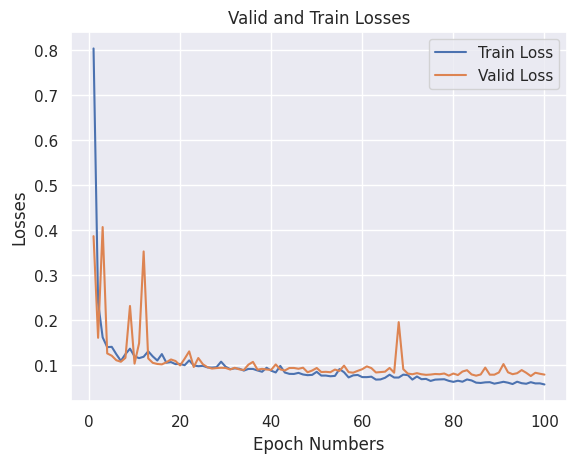

In [ ]:
train_df = pd.read_csv(os.path.join(CFG.CHECKPOINT_PATH, f"{CFG.TRAINED_MODEL}.csv"))

sns.set_theme()
ax = sns.lineplot(data=train_df, x="Epoch", y="Train_Loss", label="Train Loss")
ax = sns.lineplot(data=train_df, x="Epoch", y="Valid_Loss", label="Valid Loss")

ax.set_xlabel("Epoch Numbers")
ax.set_ylabel("Losses")
ax.set_title("Valid and Train Losses")

## 7. Test

### 7.1 Tester Class

In [ ]:
class Tester:
    def __init__(self, model, test_loader, criterion, device, checkpoint_path, model_name):
        self.model = model
        self.test_loader = test_loader
        self.criterion = criterion
        self.device = device
        self.checkpoint_path = checkpoint_path
        self.model_name = model_name

        # Load model state dictionary
        self.load_model()

    def load_model(self):
        model_path = os.path.join(self.checkpoint_path, self.model_name)
        if os.path.isfile(model_path):
            self.model.load_state_dict(torch.load(model_path))
            print(f"Model loaded from {model_path}")
        else:
            print("Model file not found. Please check the path and model_name.")

    def test(self):
        self.model.eval()
        self.model.to(self.device)
        test_loss = 0
        test_df = pd.DataFrame(columns=["Batch", "Filename", "Loss", "Time_Per_Iteration", "IoU_Score", "F1_Score", "Precision", "Recall", "Accuracy", "rle"])

        with torch.no_grad():
            for batch_index, (data, target, filenames) in enumerate(tqdm(self.test_loader)):
                data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
                target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

                batch_start_time = time.time()
                output = self.model(data)
                loss = self.criterion(output, target).item()
                test_loss += loss

                batch_time = time.time() - batch_start_time

                # Calculate and store metrics
                metrics = self.calculate_metrics(output, target)

                for i in range(data.size(0)):
                    # Process each image in the batch for RLE encoding
                    pred_mask = output[i].cpu().numpy().squeeze()  # Assuming binary mask output
                    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Thresholding

                    # RLE encode the mask
                    rle_encoded = self.rle_encode(pred_mask)

                    # Extract the first element from filename if it's a tuple
                    filename_str = filenames[i][0] if isinstance(filenames[i], tuple) else filenames[i]

                    # Append all information to test_df
                    batch_df = pd.DataFrame({
                        "Batch": [batch_index + 1],
                        "Filename": [filename_str],
                        "Loss": [loss],
                        "Time_Per_Iteration": [batch_time],
                        "IoU_Score": [metrics["IoU_Score"]],
                        "F1_Score": [metrics["F1_Score"]],
                        "Precision": [metrics["Precision"]],
                        "Recall": [metrics["Recall"]],
                        "Accuracy": [metrics["Accuracy"]],
                        "rle": [rle_encoded]  # Add RLE encoding
                    })
                    test_df = pd.concat([test_df, batch_df], ignore_index=True)

        test_loss /= len(self.test_loader)
        print(f"Test set: Average loss: {test_loss:.4f}")

        # Save test_df with all information
        test_df.to_csv(os.path.join(self.checkpoint_path, f"{self.model_name}_test_results.csv"), index=False)

        return self.model, test_df

    # ref.: https://www.kaggle.com/stainsby/fast-tested-rle
    def rle_encode(self, img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def calculate_metrics(self, y_pred, y_true):
        with torch.no_grad():
            y_pred = (y_pred > 0.5).float()
            y_true = y_true.view_as(y_pred)

            y_true = y_true.detach().cpu().numpy().flatten()
            y_pred = y_pred.detach().cpu().numpy().flatten()

            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))

            eps = 1e-8

            iou = tp / (tp + fp + fn + eps)
            precision = tp / (tp + fp + eps)
            recall = tp / (tp + fn + eps)
            f1_score = 2 * (precision * recall) / (precision + recall + eps)
            accuracy = np.sum(y_true == y_pred) / len(y_true)

            metrics = {
                "IoU_Score": iou,
                "F1_Score": f1_score,
                "Precision": precision,
                "Recall": recall,
                "Accuracy": accuracy
            }
            return metrics

### 7.2 Test Model

In [ ]:
# Initialize tester class
tester = Tester(model=attention_unet(),
                test_loader=test_loader,
                criterion=DiceLoss(),
                device=CFG.DEVICE,
                checkpoint_path=CFG.CHECKPOINT_PATH,
                model_name=CFG.TRAINED_MODEL
)

# Test the model
model, test_df = tester.test()

NameError: name 'attention_unet' is not defined

### 7.3 Results in Test

In [ ]:
# Load test results
test_df = pd.read_csv(os.path.join(CFG.CHECKPOINT_PATH, f"{CFG.TRAINED_MODEL}_test_results.csv"))

# Calculate the average of each metric
average_scores = test_df[["IoU_Score", "F1_Score", "Precision", "Recall", "Accuracy"]].mean()

# Print the averaged results of scores
print("Averaged Results of Scores:")
print(average_scores)

# Calculate and print the average and total time per iteration
average_time_per_iteration = test_df["Time_Per_Iteration"].mean()
total_time = test_df["Time_Per_Iteration"].sum()

print("\nAverage Time Per Iteration: {:.4f} seconds".format(average_time_per_iteration))
print("Total Time for All Iterations: {:.4f} seconds".format(total_time))

# Divide required items from the dataset to show them only
melted_data = test_df.melt(id_vars=["Filename", "Time_Per_Iteration"],
                           value_vars=["IoU_Score", "F1_Score", "Precision", "Recall", "Accuracy"],
                           var_name="Types of Metrics", value_name="Score")

sns.set(style="whitegrid")

plt.figure(figsize=(20, 6))
sns.violinplot(x="Types of Metrics", y="Score", data=melted_data,
               inner="quartile", linewidth=1, width=1,
               order=["IoU_Score", "F1_Score", "Precision", "Recall", "Accuracy"])

# Remove side boundaries
sns.despine(left=True)
plt.show()

### 7.4 Illustrate predictions

In [ ]:
# Choose index
index = 0
if index < 0 or index >= len(test_df):
    raise("Index out of range.")

# Extract data
data_row = test_df.iloc[index]
filename = data_row["Filename"]
rle = data_row['rle']
results = {
    "Loss": data_row["Loss"],
    "Time_Per_Iteration": data_row["Time_Per_Iteration"],
    "IoU_Score": data_row["IoU_Score"],
    "F1_Score": data_row["F1_Score"],
    "Precision": data_row["Precision"],
    "Recall": data_row["Recall"],
    "Accuracy": data_row["Accuracy"],
}

# Get images
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", filename))
label_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels", filename))
predicted_mask = rle_decode(rle, label_image.shape)

# Prepare the images and titles for display
images = [original_image, label_image, predicted_mask]
titles = ["Original Image", "Label", "Predicted Mask"]

# Use the display function
display_image(images, titles)